### Kaggle-data-competition: Understanding clouds: https://www.kaggle.com/competitions/understanding_cloud_organization


### Multiclass-image segmentation

In [8]:
from IPython.display import HTML, display
import torch
import torch.nn as nn
from torch.functional import F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
from torchvision import transforms
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder

import albumentations as albu  

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.draw import random_shapes
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib import font_manager, rc
from IPython import display
from PIL import Image
import numpy as np
import random
import glob
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
from tqdm import tqdm
import cv2

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



In [3]:
# Use the resize Img-less computationally expensive

In [10]:
PATH='/Users/noeliaotero/Documents/CAS_ML/M6_Images/understanding_cloud_organization_resized/'
TRAIN_IMG =  'train_images_64x96/'
TEST_IMG =  'test_images_64x96/'
TRAIN_CSV = 'train_64x96.csv'

In [11]:
# size:320x480

In [12]:
SIZE=[64,96]

In [13]:
# load dataframe with train labels
train_df = pd.read_csv(f'{PATH}/' + TRAIN_CSV)
sub = pd.read_csv(f'{PATH}/sample_submission.csv')
train_fns = list(glob.glob(f'{PATH}' + TRAIN_IMG +'/*.jpg'))
train_df.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,591 43 655 43 719 43 783 43 847 43 911 43 975 ...
1,0011165.jpg_Flower,2834 45 2898 45 2962 45 3026 45 3090 45 3154 4...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,513 41 577 41 641 41 705 41 769 41 833 41 897 ...


In [14]:
n_train = len(os.listdir(f'{PATH}/' + TRAIN_IMG))
n_test = len(os.listdir(f'{PATH}/' + TEST_IMG))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


In [15]:
train_df['Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Fish      5546
Flower    5546
Gravel    5546
Sugar     5546
Name: Image_Label, dtype: int64

In [16]:
# only 266 images have all four masks. It is important to remember this

In [17]:
train_df.loc[train_df['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[1]).value_counts()

Sugar     3751
Gravel    2939
Fish      2781
Flower    2365
Name: Image_Label, dtype: int64

In [18]:
train_df.loc[train_df['EncodedPixels'].isnull() == False, 'Image_Label'].apply(lambda x: x.split('_')[0]).value_counts().value_counts()

2    2372
3    1560
1    1348
4     266
Name: Image_Label, dtype: int64

In [19]:
train_df['label'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['img_id'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])


sub['label'] = sub['Image_Label'].apply(lambda x: x.split('_')[1])
sub['img_id'] = sub['Image_Label'].apply(lambda x: x.split('_')[0])

In [20]:
train_df.head()

,Image_Label,EncodedPixels,label,img_id
0,0011165.jpg_Fish,591 43 655 43 719 43 783 43 847 43 911 43 975 ...,Fish,0011165.jpg
1,0011165.jpg_Flower,2834 45 2898 45 2962 45 3026 45 3090 45 3154 4...,Flower,0011165.jpg
2,0011165.jpg_Gravel,NaN,Gravel,0011165.jpg
3,0011165.jpg_Sugar,NaN,Sugar,0011165.jpg
4,002be4f.jpg_Fish,513 41 577 41 641 41 705 41 769 41 833 41 897 ...,Fish,002be4f.jpg


In [21]:
sub.head()

,Image_Label,EncodedPixels,label,img_id
0,002f507.jpg_Fish,1 1,Fish,002f507.jpg
1,002f507.jpg_Flower,1 1,Flower,002f507.jpg
2,002f507.jpg_Gravel,1 1,Gravel,002f507.jpg
3,002f507.jpg_Sugar,1 1,Sugar,002f507.jpg
4,0035ae9.jpg_Fish,1 1,Fish,0035ae9.jpg


### Visualize original images and masks (with the corresponding labels)

In [22]:
#Create mask based on train_df, image name and shape
def rle_decode(mask_rle, shape=SIZE):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')  


def make_mask(df, image_name,
              shape= SIZE):
    encoded_masks = df.loc[df['img_id'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)

    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :, idx] = mask

    return masks

In [23]:
#show a specific image
def ShowImg(trainData,imgName, size):
    image = Image.open(PATH + TRAIN_IMG + imgName)
    print("Original Img")
    plt.imshow(image)
    # shape of image : (1400, 2100, 3)
    plt.show()
    ss=trainData.loc[trainData['img_id']==imgName, 'EncodedPixels']
    for row in ss:
        print(trainData.loc[trainData['EncodedPixels']==row, "label"])
        try: # label might not be there!
            mask = rle_decode(row)
        except Exception as exception:
            mask = np.zeros((size[0], size[1]))
            continue
            
        plt.imshow(image)
        plt.imshow(mask, alpha=0.3, cmap='gray')
        plt.show()

In [24]:
imageToPlot = random.choice(train_df['img_id'])

Original Img


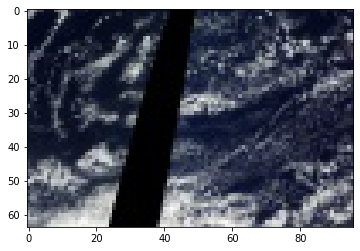

20536    Fish
Name: label, dtype: object


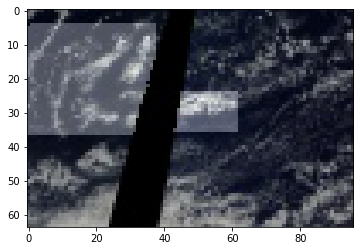

Series([], Name: label, dtype: object)
20538    Gravel
Name: label, dtype: object


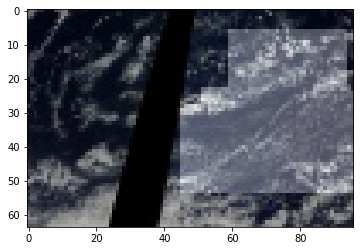

20539    Sugar
Name: label, dtype: object


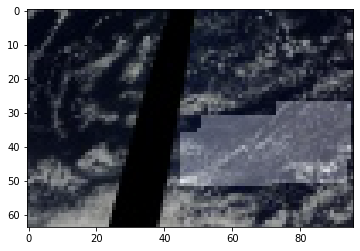

In [25]:
ShowImg(train_df,imageToPlot, SIZE)

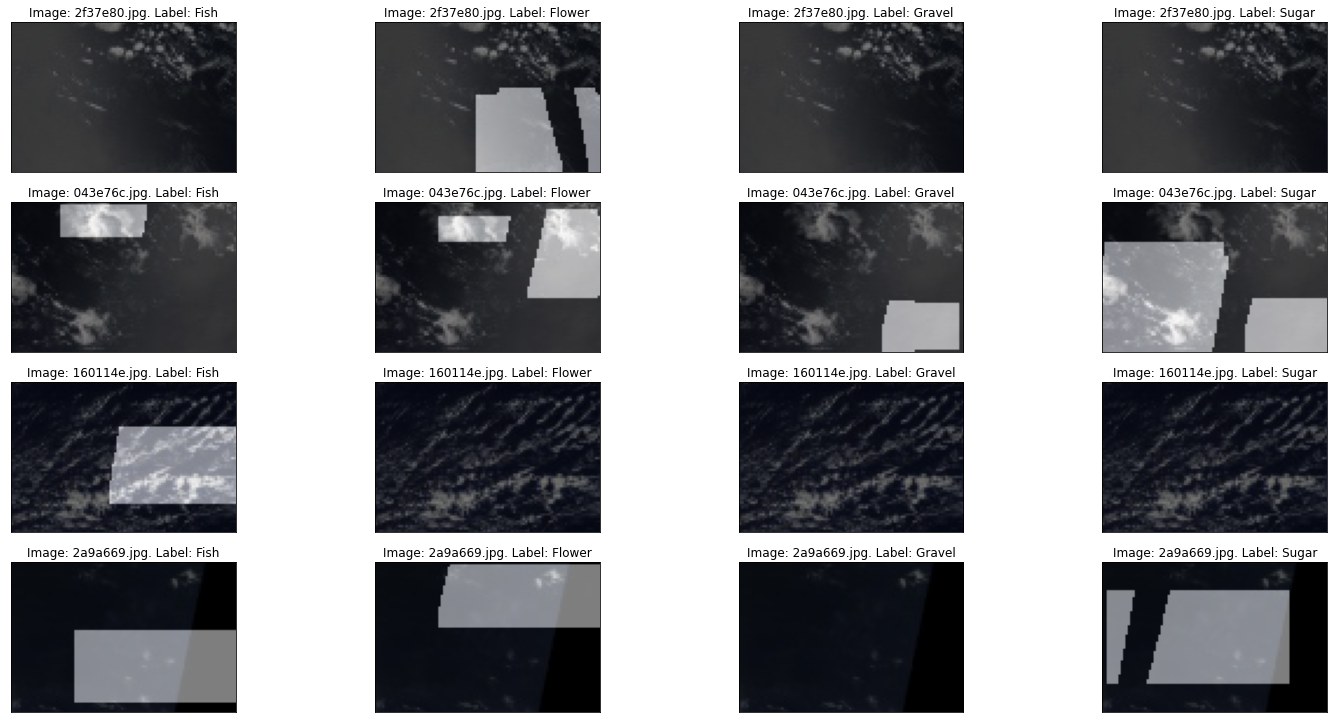

In [26]:
# visualize the images
fig = plt.figure(figsize=(25, 16))
for j, im_id in enumerate(np.random.choice(train_df['img_id'].unique(), 4)):
    for i, (idx, row) in enumerate(train_df.loc[train_df['img_id'] == im_id].iterrows()):
        ax = fig.add_subplot(5, 4, j * 4 + i + 1, xticks=[], yticks=[])
        im = Image.open(f"{PATH}/train_images_320x480/{row['Image_Label'].split('_')[0]}")
        plt.imshow(im)
        mask_rle = row['EncodedPixels']
        try: # label might not be there!
            mask = rle_decode(mask_rle)
        except:
            mask = np.zeros((SIZE[0], SIZE[1]))
        plt.imshow(mask, alpha=0.5, cmap='gray')
        ax.set_title(f"Image: {row['Image_Label'].split('_')[0]}. Label: {row['label']}")

### Simple data generator in pytorch

In [27]:
#reshape after using albumentation
def ConvertToTensorFormat(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [40]:
#preprocess for specific network used
def get_preprocessing(preprocessing_fn=None):
    if preprocessing_fn is not None:
        _transform = [
            albu.Lambda(image=preprocessing_fn),
            albu.Lambda(image=ConvertToTensorFormat, mask=ConvertToTensorFormat),
        ]
    else:
        _transform = [
            albu.Normalize(),
            albu.Lambda(image=ConvertToTensorFormat, mask=ConvertToTensorFormat),
        ]
    return albu.Compose(_transform)
#augmentation for training data
def get_training_augmentation(p=0.5):
    train_transform = [
        albu.Resize(80, 160),
       # albu.Resize(320, 640),
        albu.HorizontalFlip(p=0.25),
        albu.VerticalFlip(p=0.25),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0)
    ]
    return albu.Compose(train_transform)

#for validation dataset it is just resize
def get_validation_augmentation():
    train_transform = [
        albu.Resize(80, 160)
    ]
    return albu.Compose(train_transform)


In [41]:
class CloudDataset(Dataset):
    def __init__(self,data,datatype,transforms,img_ids,preprocessing=None):
        self.data=data
        self.preprocessing=preprocessing
        self.transforms=transforms
        self.img_ids=img_ids
        if (datatype=="train"):
            self.imgFolder=PATH+ TRAIN_IMG
        if (datatype=="test"):
            self.imgFolder=PATH+ TEST_IMG

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]

        mask = make_mask(self.data, image_name)
        image_path = os.path.join(self.imgFolder, image_name)
        
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
            
            
        return img, mask

    def __len__(self):
        return len(self.img_ids)  

In [65]:
### split into train and val
# split the training data into train and validation set (stratified)
train_image_ids=train_df.img_id.unique()
reduced_train_ids = train_image_ids[0:1000]

In [66]:
X_train_ids, X_val_ids = train_test_split(reduced_train_ids, test_size=0.20, random_state=42)

In [67]:
bs = 10
num_workers = 0

In [68]:
train_dataset = CloudDataset(data=train_df, datatype='train', img_ids=X_train_ids, transforms = get_training_augmentation(), preprocessing=get_preprocessing(None))
valid_dataset = CloudDataset(data=train_df, datatype='train', img_ids=X_val_ids, transforms = get_validation_augmentation(), preprocessing=get_preprocessing(None))

In [69]:
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers)
loaders = {
    "train": train_loader,
    "valid": valid_loader
}

In [70]:
# Check the shapes

In [71]:
sample, mask = next(iter(train_loader))

In [72]:
def visualize(image, mask, original_image=None, original_mask=None, gray=True):
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        if gray:
            ax[0].imshow(image, cmap='gray')
        else:    
            ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[i, :, :])
            ax[i + 1].set_title(f"Mask {class_dict[i]}", fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title("Original image", fontsize=fontsize)

        for i in range(4):
            ax[0, i + 1].imshow(original_mask[i, :, :])
            ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)

        ax[1, 0].imshow(image)
        ax[1, 0].set_title("Transformed image", fontsize=fontsize)

        for i in range(4):
            ax[1, i + 1].imshow(mask[i, :, :])
            ax[1, i + 1].set_title(
                f"Transformed mask {class_dict[i]}", fontsize=fontsize
            )



In [73]:
# Look at the images from loader

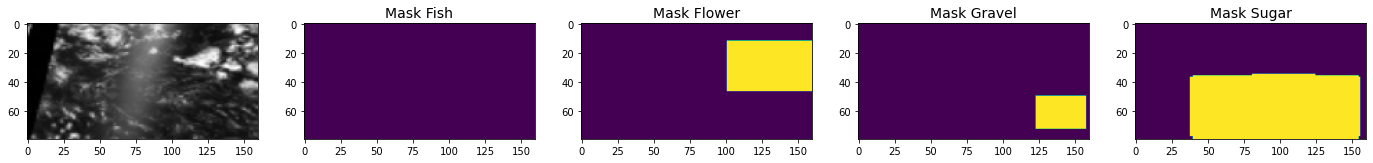

In [74]:
visualize(sample[1,0,:,:],mask[1])

In [75]:
class_names = ["Fish", "Flower", "Gravel", "Sugar"]

### U-Net

In [76]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [77]:
class U_net(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(U_net, self).__init__()
            
        # downsampling part
        self.DownConv1 = self.ContractBlock(in_channels, 32, 7, 3)
        self.DownConv2 = self.ContractBlock(32, 64, 3, 1)
        self.DownConv3 = self.ContractBlock(64, 128, 3, 1)
            
        # upsampling part
        self.UpConv3 = self.ExpandBlock(128, 64, 3, 1)
        self.UpConv2 = self.ExpandBlock(64*2, 32, 3, 1)
        self.UpConv1 = self.ExpandBlock(32*2, out_channels, 3, 1)
        
    def __call__(self, x):
         
        DownConv1 = self.DownConv1(x)
        DownConv2 = self.DownConv2(DownConv1) 
        DownConv3 = self.DownConv3(DownConv2)   
        UpConv3   = self.UpConv3 (DownConv3)
        UpConv2   = self.UpConv2 (torch.cat([UpConv3, DownConv2], 1))
        UpConv1   = self.UpConv1 (torch.cat([UpConv2, DownConv1], 1))
        
        return UpConv1
        
        
    def ContractBlock(self, in_channels, out_channels, kernel_size, padding):
        
        contract = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
        return contract



    def ExpandBlock(self, in_channels, out_channels, kernel_size, padding):
        
        expand = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        
            nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) )
    
        return expand

#### Loss functions:

In [78]:
# The Dice coefficient is a common metric for pixel segmentation:
# Credits: https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [79]:
### The BCE_dice: This loss combines Dice loss with the standard binary cross-entropy (BCE) loss that is generally the default for segmentation models. 
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [80]:
### The IoU metric, or Jaccard Index, is similar to the Dice metric and is calculated as the ratio between the overlap of the positive instances between two sets, 
### and their mutual combined values:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [81]:
criterion = DiceBCELoss()

In [82]:
#model = UNet(n_channels=3, n_classes=4).float()

In [83]:
#### testing----------
U_net_model = U_net(3, 4)
rgb_img, mask = next(iter(train_loader))
output = U_net_model(rgb_img)
output.shape

torch.Size([10, 4, 80, 160])

In [84]:
# Use GPU if it is available
model = U_net_model.to(device)

In [85]:
# Set the optimizer 
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [86]:
# number of epochs to train the model
n_epochs = 10
#optimizer = optim.Adam(model.parameters(), lr=0.12)
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    
    # Train #
    model.train()
    print('epoch = ', epoch)
    bar = tqdm(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
    #for batch_idx, (data, label) in enumerate(train_loader):
        
       # data, target = data, label
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tqdm(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
        #for batch_idx, (data, label) in enumerate(valid_loader):
            
            #data, target = data, label
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
           # dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
           # dice_score +=  dice_cof * data.size(0)
           
        
   # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
   # dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    #dice_score_list.append(dice_score)
    #lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
  

epoch =  1


100%|██████████| 20/20 [00:07<00:00,  2.85it/s, dice_score=0, valid_loss=0]


Epoch: 1  Training Loss: 1.475613  Validation Loss: 1.463228 Dice Score: 0.000000
epoch =  2


100%|██████████| 20/20 [00:07<00:00,  2.83it/s, dice_score=0, valid_loss=0]


Epoch: 2  Training Loss: 1.469392  Validation Loss: 1.459490 Dice Score: 0.000000
epoch =  3


100%|██████████| 20/20 [00:06<00:00,  2.91it/s, dice_score=0, valid_loss=0]


Epoch: 3  Training Loss: 1.468739  Validation Loss: 1.458115 Dice Score: 0.000000
epoch =  4


100%|██████████| 20/20 [00:06<00:00,  2.88it/s, dice_score=0, valid_loss=0]


Epoch: 4  Training Loss: 1.463533  Validation Loss: 1.456305 Dice Score: 0.000000
epoch =  5


100%|██████████| 20/20 [00:06<00:00,  2.89it/s, dice_score=0, valid_loss=0]


Epoch: 5  Training Loss: 1.455823  Validation Loss: 1.451914 Dice Score: 0.000000
epoch =  6


100%|██████████| 20/20 [00:06<00:00,  2.87it/s, dice_score=0, valid_loss=0]


Epoch: 6  Training Loss: 1.454995  Validation Loss: 1.455054 Dice Score: 0.000000
epoch =  7


100%|██████████| 20/20 [00:06<00:00,  2.91it/s, dice_score=0, valid_loss=0]


Epoch: 7  Training Loss: 1.454549  Validation Loss: 1.446892 Dice Score: 0.000000
epoch =  8


100%|██████████| 20/20 [00:06<00:00,  2.90it/s, dice_score=0, valid_loss=0]


Epoch: 8  Training Loss: 1.449076  Validation Loss: 1.453963 Dice Score: 0.000000
epoch =  9


100%|██████████| 20/20 [00:06<00:00,  2.88it/s, dice_score=0, valid_loss=0]


Epoch: 9  Training Loss: 1.451562  Validation Loss: 1.443913 Dice Score: 0.000000
epoch =  10


100%|██████████| 20/20 [00:06<00:00,  2.89it/s, dice_score=0, valid_loss=0]

Epoch: 10  Training Loss: 1.446804  Validation Loss: 1.440297 Dice Score: 0.000000


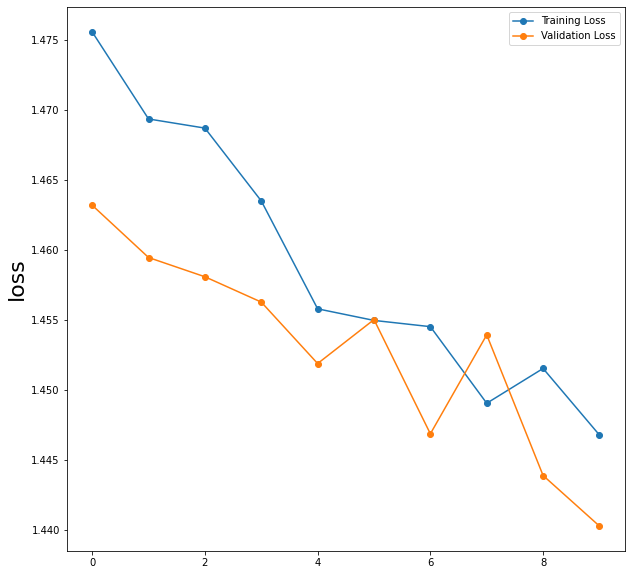

In [87]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

### Show model output

In [101]:
data, target = next(iter(valid_loader))
output = model(data)
data = data.detach().numpy()
target = target.detach().numpy()
output2 = output.detach().numpy()

In [102]:
predicted_masks = (output.squeeze() >= 0.5).float().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

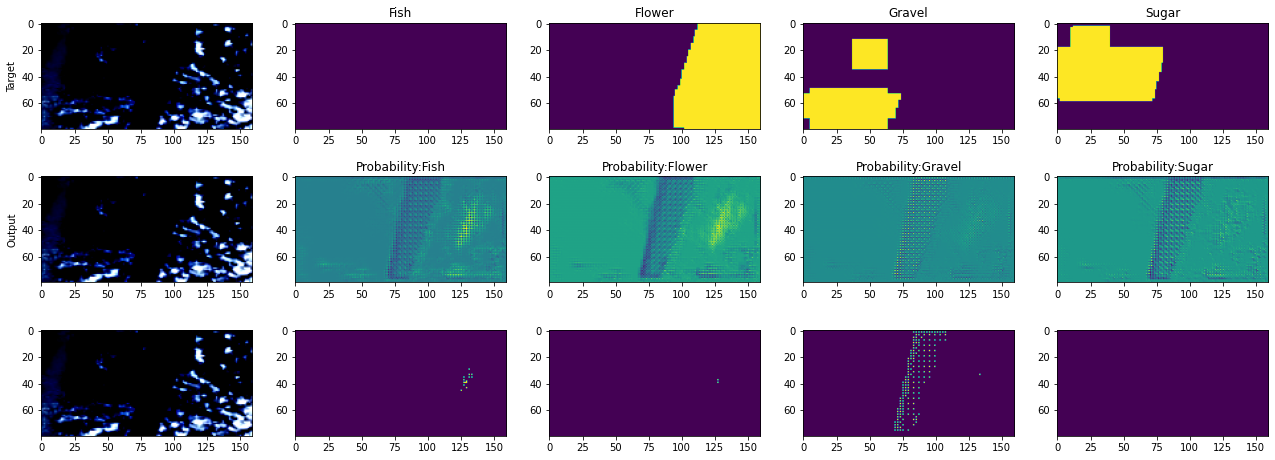

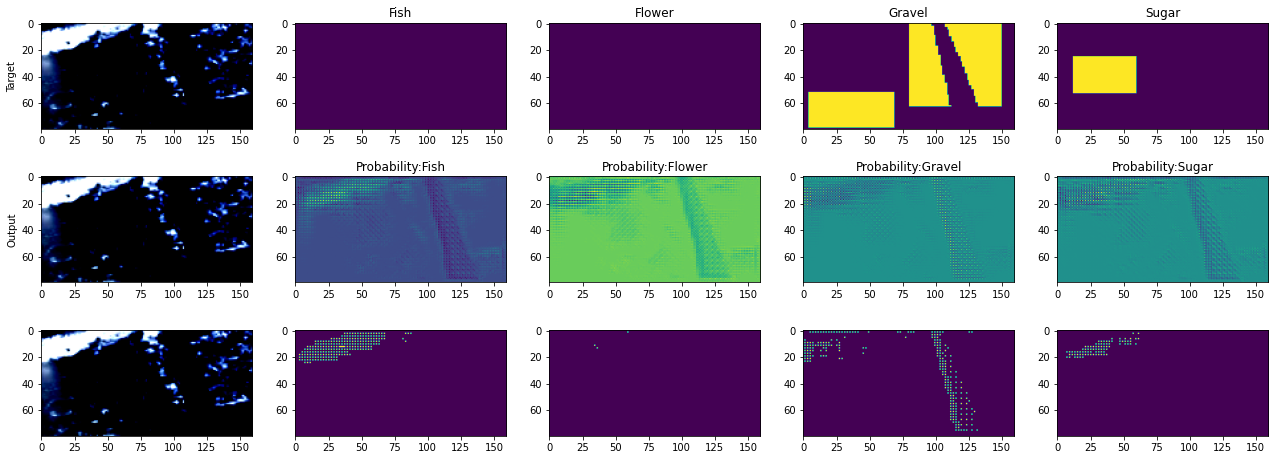

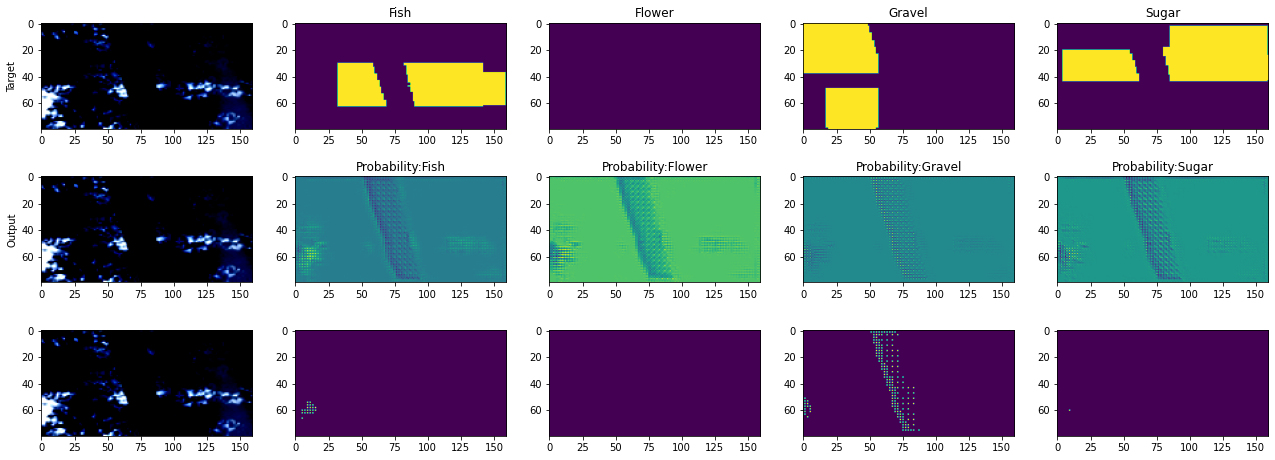

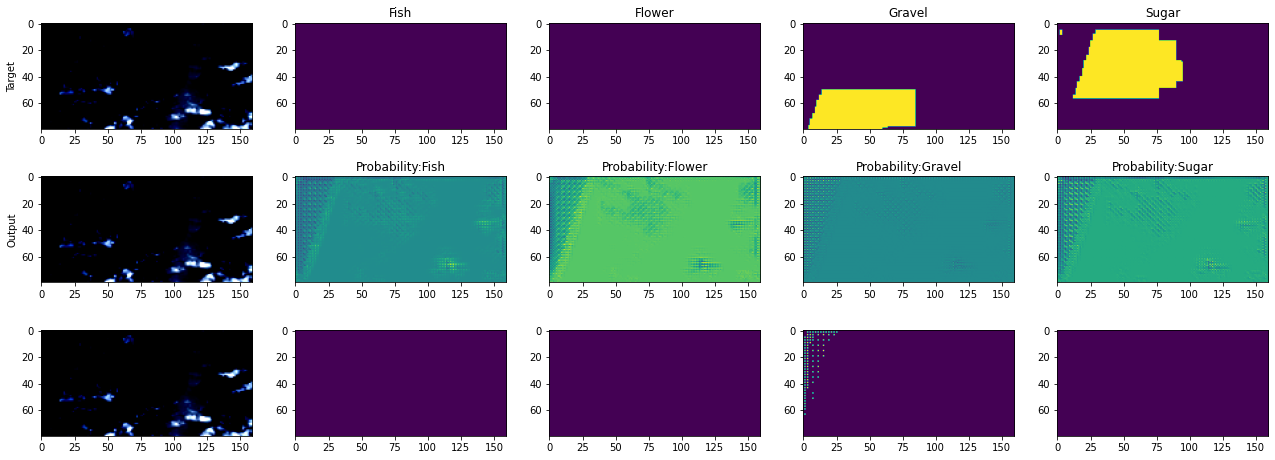

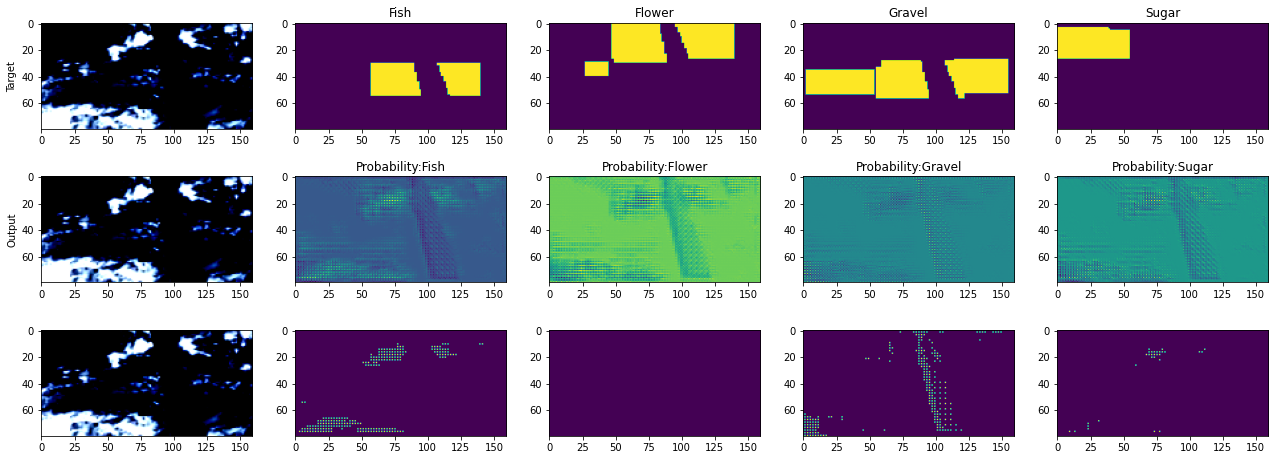

In [103]:
for i in range(5):
    f, ax = plt.subplots(ncols=5, nrows=3, figsize=(22,8))
    ax[0][0].imshow(data[i, ...].transpose(1,2,0))
    ax[1][0].imshow(data[i, ...].transpose(1,2,0))
    ax[2][0].imshow(data[i, ...].transpose(1,2,0))

    ax[0][0].set_ylabel('Target')
    ax[1][0].set_ylabel('Output')
    
    for j in range(0, 4):
        ax[0][j + 1].set_title(class_names[j])
        ax[0][j + 1].imshow(target[i, j, :, :])
        ax[1][j + 1].set_title("Probability:" + class_names[j])
        ax[1][j + 1].imshow(output2[i, j, :, :])
        ax[2][j + 1].imshow(predicted_masks[i, j, :, :])
        

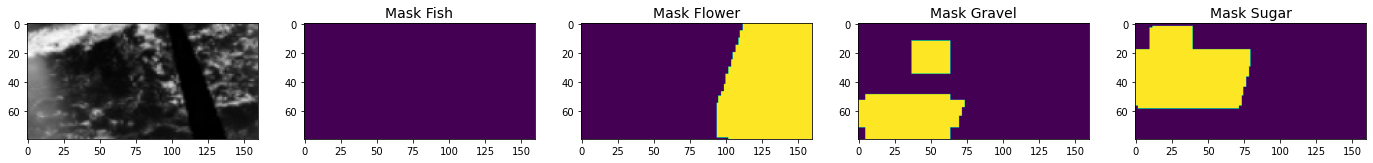

In [111]:
#visualize(data[1,0,:,:],target[0])

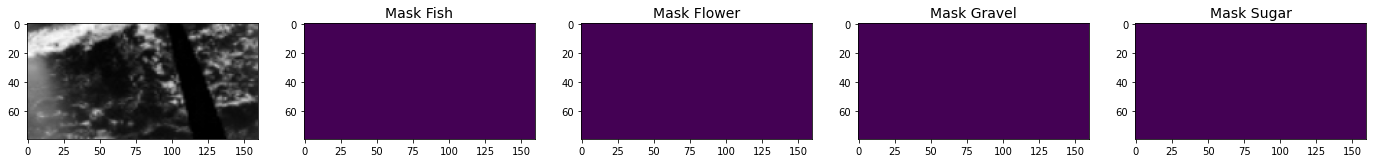

In [115]:
#visualize(data[1,0,:,:],output2[0]>0.5)

In [ ]:
## try other models

In [91]:
class Mynetwork(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Mynetwork, self).__init__()
        
        # define e.g. layers here e.g.
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=20, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=3, padding=1)
        self.upscale1 = nn.ConvTranspose2d(20, 20, kernel_size=2, stride=2)
        self.upscale2 = nn.ConvTranspose2d(20, 20, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=out_channels, kernel_size=3, padding=1)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        
        # define the sequence of operations in the network including e.g. activations
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = F.relu(self.upscale1(x))
        x = F.relu(self.upscale2(x))
        x = self.conv4(x)
                
        return x

In [94]:
my_model = Mynetwork(3, 4)
rgb_img, mask = next(iter(train_loader))
output = my_model(rgb_img)
output.shape

torch.Size([10, 4, 80, 160])

In [95]:
criterion = DiceBCELoss()

In [96]:
# number of epochs to train the model
n_epochs = 10
#optimizer = optim.Adam(model.parameters(), lr=0.12)
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    
    # Train #
    my_model.train()
    print('epoch = ', epoch)
    bar = tqdm(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
    #for batch_idx, (data, label) in enumerate(train_loader):
        
       # data, target = data, label
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = my_model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    ######################    
    # validate the model #
    ######################
    my_model.eval()
    del data, target
    with torch.no_grad():
        bar = tqdm(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
        #for batch_idx, (data, label) in enumerate(valid_loader):
            
            #data, target = data, label
            # forward pass: compute predicted outputs by passing inputs to the model
            output = my_model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
           # dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
           # dice_score +=  dice_cof * data.size(0)
           
        
   # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
   # dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    #dice_score_list.append(dice_score)
    #lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
  

epoch =  1


  0%|          | 0/80 [00:00<?, ?it/s, train_loss=0]/Users/noeliaotero/opt/anaconda3/envs/CASM6/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 20/20 [00:01<00:00, 10.30it/s, dice_score=0, valid_loss=0]


Epoch: 1  Training Loss: 1.469516  Validation Loss: 1.455592 Dice Score: 0.000000
epoch =  2


100%|██████████| 20/20 [00:01<00:00, 10.93it/s, dice_score=0, valid_loss=0]


Epoch: 2  Training Loss: 1.466074  Validation Loss: 1.455592 Dice Score: 0.000000
epoch =  3


100%|██████████| 20/20 [00:01<00:00, 10.95it/s, dice_score=0, valid_loss=0]


Epoch: 3  Training Loss: 1.469966  Validation Loss: 1.455592 Dice Score: 0.000000
epoch =  4


100%|██████████| 20/20 [00:01<00:00, 10.16it/s, dice_score=0, valid_loss=0]


Epoch: 4  Training Loss: 1.469358  Validation Loss: 1.455592 Dice Score: 0.000000
epoch =  5


100%|██████████| 20/20 [00:01<00:00, 10.12it/s, dice_score=0, valid_loss=0]


Epoch: 5  Training Loss: 1.468269  Validation Loss: 1.455592 Dice Score: 0.000000
epoch =  6


100%|██████████| 20/20 [00:01<00:00, 10.92it/s, dice_score=0, valid_loss=0]


Epoch: 6  Training Loss: 1.466764  Validation Loss: 1.455592 Dice Score: 0.000000
epoch =  7


100%|██████████| 20/20 [00:01<00:00, 10.98it/s, dice_score=0, valid_loss=0]


Epoch: 7  Training Loss: 1.467992  Validation Loss: 1.455592 Dice Score: 0.000000
epoch =  8


100%|██████████| 20/20 [00:01<00:00, 10.20it/s, dice_score=0, valid_loss=0]


Epoch: 8  Training Loss: 1.465540  Validation Loss: 1.455592 Dice Score: 0.000000
epoch =  9


100%|██████████| 20/20 [00:01<00:00, 10.03it/s, dice_score=0, valid_loss=0]


Epoch: 9  Training Loss: 1.468681  Validation Loss: 1.455592 Dice Score: 0.000000
epoch =  10


100%|██████████| 20/20 [00:01<00:00, 11.22it/s, dice_score=0, valid_loss=0]

Epoch: 10  Training Loss: 1.468285  Validation Loss: 1.455592 Dice Score: 0.000000


In [104]:
data, target = next(iter(valid_loader))
output = my_model(data)
data = data.detach().numpy()
target = target.detach().numpy()
output2 = output.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

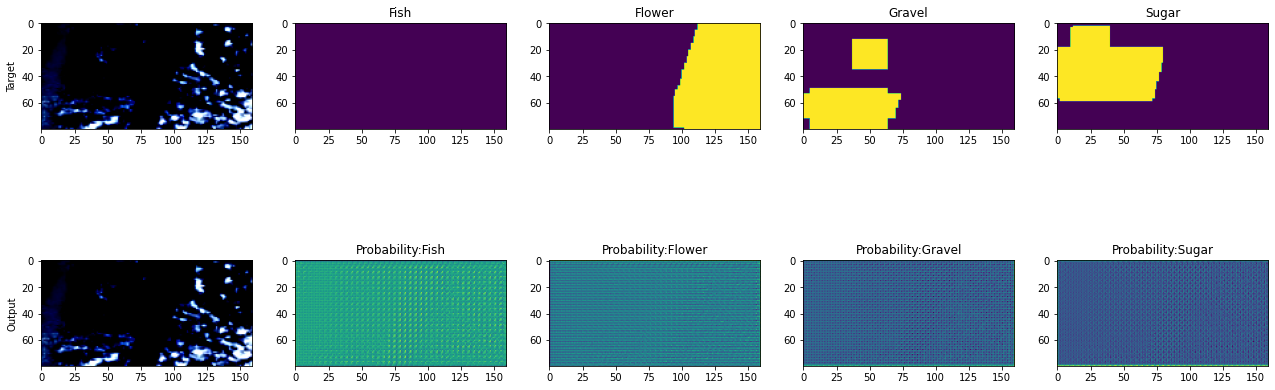

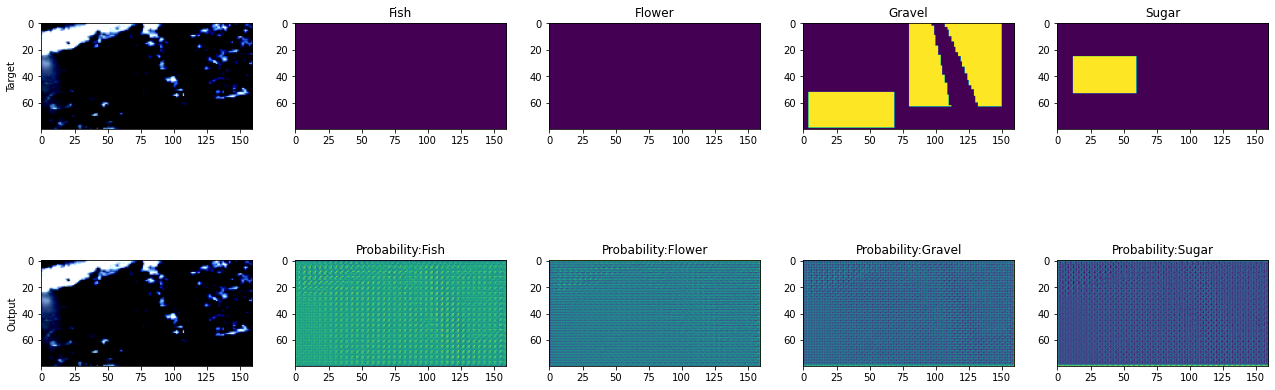

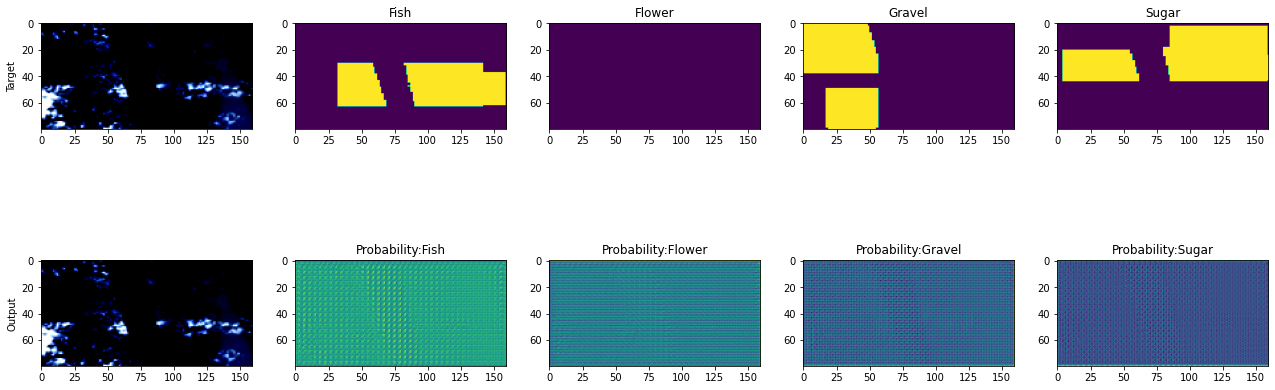

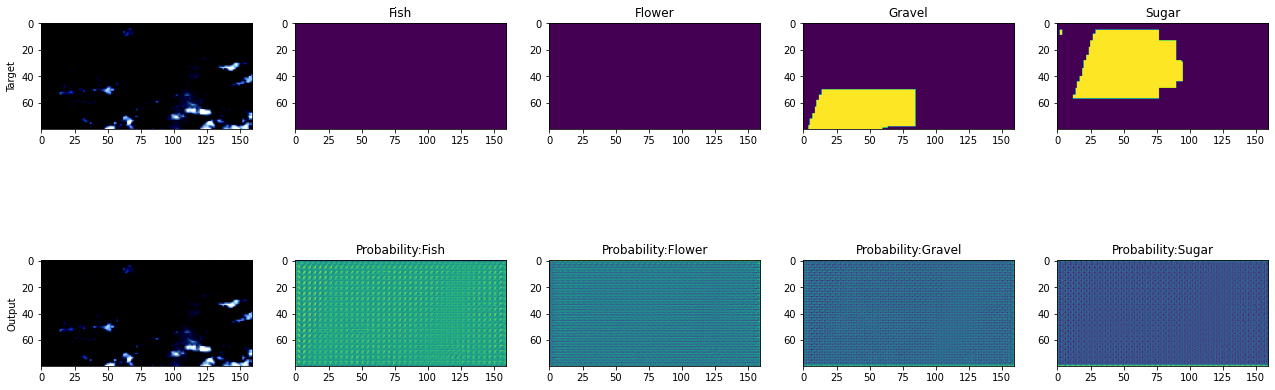

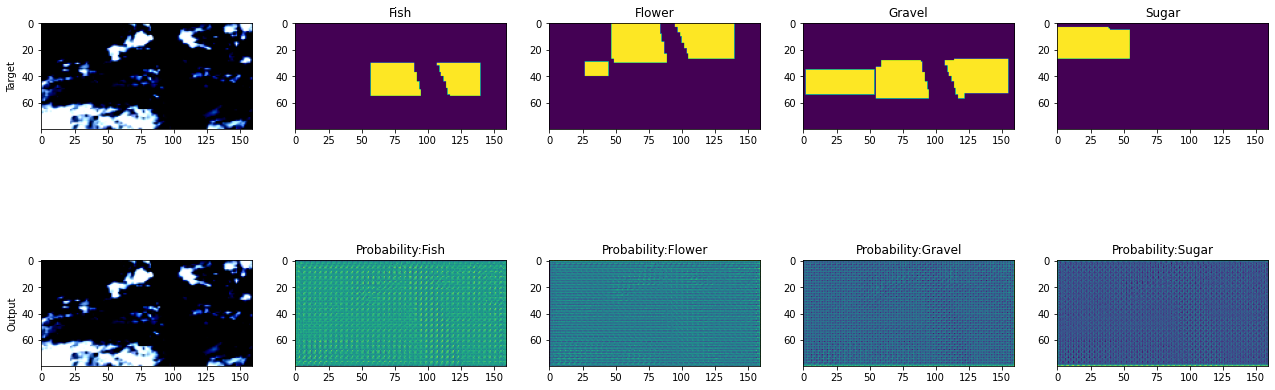

In [106]:
for i in range(5):
    f, ax = plt.subplots(ncols=5, nrows=2, figsize=(22,8))
    ax[0][0].imshow(data[i, ...].transpose(1,2,0))
    ax[1][0].imshow(data[i, ...].transpose(1,2,0))

    ax[0][0].set_ylabel('Target')
    ax[1][0].set_ylabel('Output')
    
    for j in range(0, 4):
        ax[0][j + 1].set_title(class_names[j])
        ax[0][j + 1].imshow(target[i, j, :, :])
        ax[1][j + 1].set_title("Probability:" + class_names[j])
        ax[1][j + 1].imshow(output2[i, j, :, :])